# Purpose

Calculate content of mgcs scores across manually curated categories

Do for brain mgcs and PBMC mgcs

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.ticker import ScalarFormatter
import statsmodels.api as sm
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Brain mgcs content

In [2]:
def load_mgcs(path_to_json, mgcs_name:str)->pd.DataFrame:
	# Load the mgcs dictionary
	# Load the JSON file into a dictionary
	with open(path_to_json, 'r') as json_file:
		mgcs= json.load(json_file)
	# Convert the dictionary to a DataFrame
	mgcs = pd.DataFrame(list(mgcs.items()), columns=['gene', mgcs_name])
	return mgcs

brain_mgcs = load_mgcs(path_to_json="data/brain_mges.json", mgcs_name='brainmgcs')

In [14]:
def load_GO_curations(patho_to_curations="/space/grp/aadrian/Pseudobulk_Function_Pipeline_HighRes/bin/preprocessing/preprocessGO_pipe/data/2024_march/data/GOCurations.tsv"):
	GO_curations = pd.read_csv(patho_to_curations, sep = "\t")

	def melt_curations(df:pd.DataFrame)->pd.DataFrame:
		"""
		create a new column that is a melted version of the GO term curations

		Parameters:
		- df: pandas DataFrame

		Returns:
		- pandas DataFrame with a new column 'meta' indicating the curation category of the GO term
		"""
		# Create a new column using conditions
		meta = df.apply(lambda row: 'Brain' if row['BrainAffiliated'] == 'T' else ('PBMC' if row['PBMCAffiliated'] == 'T' else "Neither"), axis=1)
		df['meta']=meta
		
		return df
	GO_curations = melt_curations(GO_curations)
	return GO_curations

GO_curations = load_GO_curations()

In [4]:
# Merge the DataFrame with the dictionary DataFrame on 'id'
GO_curations = pd.merge(GO_curations, brain_mgcs, left_on='id', right_on='gene')
GO_curations.head()

,id,name,namespace,CTAffiliated,BrainAffiliated,PBMCAffiliated,def,meta,gene,brainmgcs
0,GO:0000045,autophagosome assembly,biological_process,F,F,F,The formation of a double membrane-bounded str...,Neither,GO:0000045,0.191122
1,GO:0000070,mitotic sister chromatid segregation,biological_process,F,F,F,The cell cycle process in which replicated hom...,Neither,GO:0000070,0.007972
2,GO:0000077,DNA damage checkpoint signaling,biological_process,F,F,F,A signal transduction process that contributes...,Neither,GO:0000077,0.092560
3,GO:0000079,regulation of cyclin-dependent protein serine/...,biological_process,F,F,F,"Any process that modulates the frequency, rate...",Neither,GO:0000079,0.082087
4,GO:0000082,G1/S transition of mitotic cell cycle,biological_process,F,F,F,The mitotic cell cycle transition by which a c...,Neither,GO:0000082,0.365410


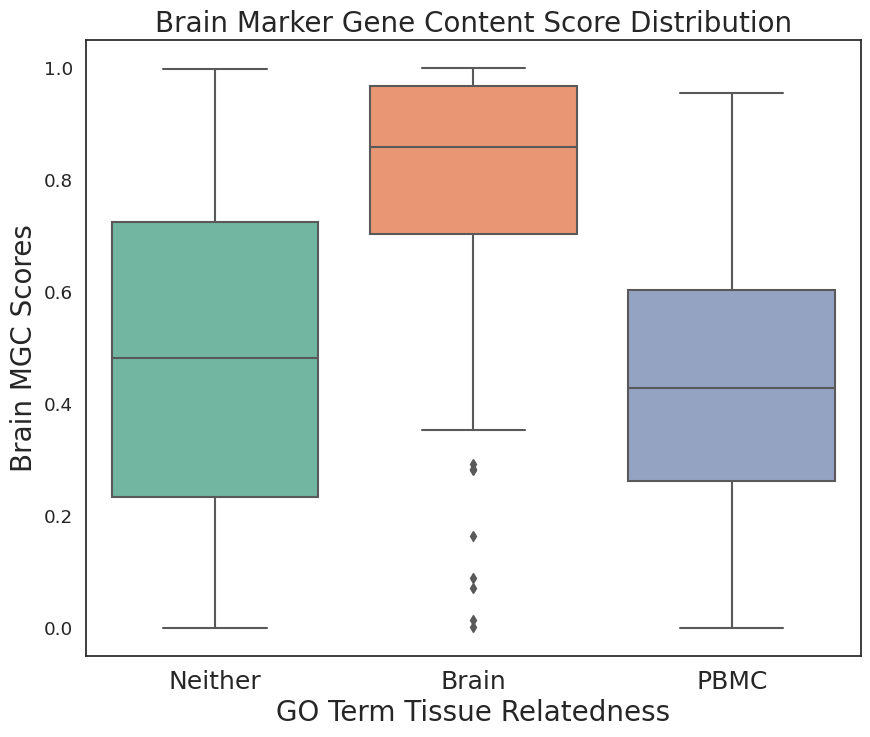

In [5]:
def plot_content(GO_curations:pd.DataFrame, ycol:str, title:str, ylabel:str, savefig:str)->None:
    """Plot the mgcs scores across GO Term Curated categories   
    Args:
        GO_curations (pd.DataFrame): df containing info about GO term, mgcs, and curated category
        title (str): Title of plot
    """
    sns.set(style="white", font_scale=1.2)# Set up plot parameters
    plt.figure(figsize=(10, 8))  # Adjust figure size    
    # Define the custom palette
    set2_colors = sns.color_palette("Set2")
    custom_palette = {
        "Neither": set2_colors[0],
        "Brain": set2_colors[1],
        "PBMC": set2_colors[2]
}
    # Create boxplot
    g = sns.boxplot(data=GO_curations, x='meta', y=ycol, palette=custom_palette)
    # Set y-axis to log scale
    # Use ScalarFormatter to avoid scientific notation
    g.yaxis.set_major_formatter(ScalarFormatter())
    # Set y-axis to log scale
    # g.set_yscale('log')
    # Add titles and labels
    plt.title(title, fontsize=20)
    plt.xlabel("GO Term Tissue Relatedness", fontsize=20)
    plt.ylabel(ylabel, fontsize=20)  # Use LaTeX for subscript with capital L
    

    # Change x-axis tick names
    g.set_xticklabels(["Neither", "Brain", "PBMC"], fontsize = 18)  # Adjust x-axis tick labels
    # g.set_yticklabels(g.get_yticklabels(), fontsize = 16)  # Adjust x-axis tick labels

    # Saveplot
    plt.savefig(savefig, dpi = 300, bbox_inches='tight')
    plt.show()

os.makedirs('figs', exist_ok=True)
plot_content(GO_curations=GO_curations,  ycol='brainmgcs', title = "Brain Marker Gene Content Score Distribution", ylabel = 'Brain MGC Scores', savefig = "figs/brain_mgcs.png")

ANOVA and tukey

In [6]:
def print_anovatukey(GO_curations:pd.DataFrame, ycol:str)->None:
	print("~~~ANOVA~~~~~")
	model = ols(f'brainmgcs ~ {ycol}', data=GO_curations).fit()
	anova_table = sm.stats.anova_lm(model, typ=2)
	print(anova_table)
	print('\n\n')
	print("~~~~~TUKEYHSD~~~~~")
	tukey = pairwise_tukeyhsd(endog=GO_curations[ycol], groups=GO_curations['meta'], alpha=0.01)
	print(tukey.summary())
	print(tukey.pvalues)

print_anovatukey(GO_curations=GO_curations, ycol='brainmgcs')



~~~ANOVA~~~~~
                 sum_sq      df             F  PR(>F)
brainmgcs  1.163102e+02     1.0  6.978631e+32     0.0
Residual   2.323327e-28  1394.0           NaN     NaN



~~~~~TUKEYHSD~~~~~
 Multiple Comparison of Means - Tukey HSD, FWER=0.01  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
  Brain Neither  -0.3006    0.0 -0.3842  -0.217   True
  Brain    PBMC  -0.3483    0.0 -0.4562 -0.2405   True
Neither    PBMC  -0.0478 0.1583 -0.1237  0.0282  False
------------------------------------------------------
[2.44249065e-13 2.44249065e-13 1.58292362e-01]


# PBMC mgcs content

In [10]:
# Load the mgcs for pbmc
pbmc_mgcs = load_mgcs("data/pbmc_mges.json", 'pbmcmgcs')

# Merge the DataFrame with the dictionary DataFrame on 'id'
GO_curations = pd.merge(GO_curations, pbmc_mgcs, on='gene')
GO_curations.head()

,id,name,namespace,CTAffiliated,BrainAffiliated,PBMCAffiliated,def,meta,gene,brainmgcs,pbmcmges,pbmcmgcs
0,GO:0000045,autophagosome assembly,biological_process,F,F,F,The formation of a double membrane-bounded str...,Neither,GO:0000045,0.191122,0.373829,0.373829
1,GO:0000070,mitotic sister chromatid segregation,biological_process,F,F,F,The cell cycle process in which replicated hom...,Neither,GO:0000070,0.007972,0.006813,0.006813
2,GO:0000077,DNA damage checkpoint signaling,biological_process,F,F,F,A signal transduction process that contributes...,Neither,GO:0000077,0.092560,0.080075,0.080075
3,GO:0000079,regulation of cyclin-dependent protein serine/...,biological_process,F,F,F,"Any process that modulates the frequency, rate...",Neither,GO:0000079,0.082087,0.948514,0.948514
4,GO:0000082,G1/S transition of mitotic cell cycle,biological_process,F,F,F,The mitotic cell cycle transition by which a c...,Neither,GO:0000082,0.365410,0.591012,0.591012


In [8]:
pbmc_mgcs

,gene,pbmcmges
0,GO:0000045,0.373829
1,GO:0000070,0.006813
2,GO:0000077,0.080075
3,GO:0000079,0.948514
4,GO:0000082,0.591012
...,...,...
1397,GO:2001237,0.554021
1398,GO:2001238,0.723075
1399,GO:2001240,0.991108
1400,GO:2001243,0.681674


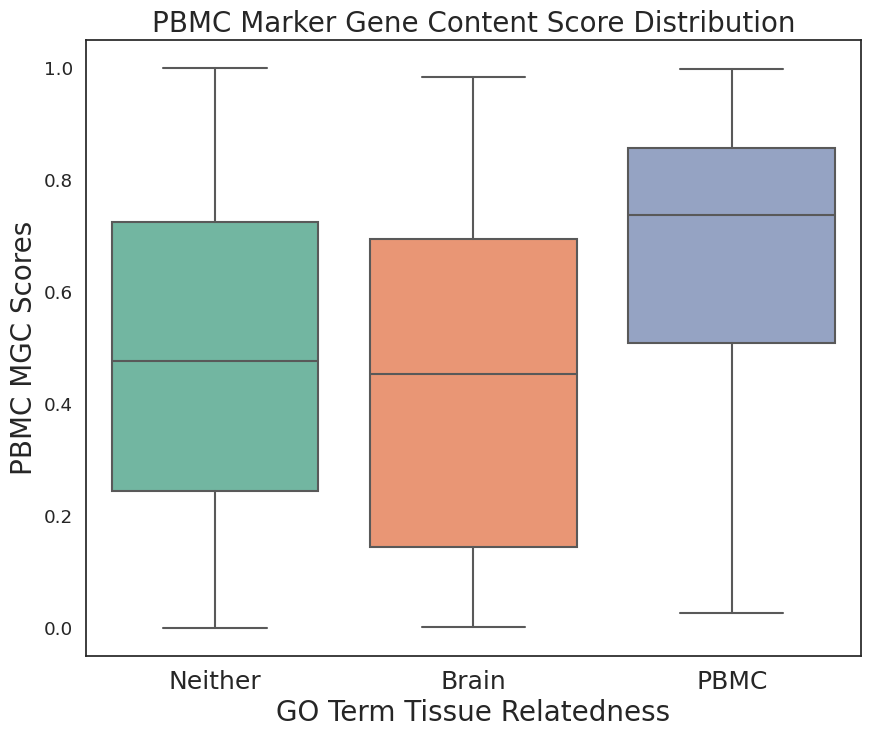

In [11]:
os.makedirs('figs', exist_ok=True)
plot_content(GO_curations=GO_curations, ycol='pbmcmgcs', title = "PBMC Marker Gene Content Score Distribution", ylabel = 'PBMC MGC Scores', savefig = "figs/pbmc_mgcs.png")

In [12]:
print_anovatukey(GO_curations=GO_curations, ycol='pbmcmgcs')


~~~ANOVA~~~~~
              sum_sq      df         F    PR(>F)
pbmcmgcs    0.813698     1.0  9.821035  0.001761
Residual  115.496511  1394.0       NaN       NaN



~~~~~TUKEYHSD~~~~~
 Multiple Comparison of Means - Tukey HSD, FWER=0.01 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
  Brain Neither   0.0597 0.1035 -0.0258 0.1451  False
  Brain    PBMC   0.2404    0.0  0.1302 0.3506   True
Neither    PBMC   0.1807    0.0  0.1031 0.2583   True
-----------------------------------------------------
[1.03525538e-01 7.93852872e-10 4.77493600e-11]
